In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as scp
import itertools
import collections

# qPCR analysis

??? Wetlab methods description ??? 

??? Analysis methods description ???

qPCR data has 

In [2]:
#Read in datasets from Jui (reshaped by me in excel)
qpcr_df = pd.read_csv('input_csvs/qPCR_short_long_CTs.csv')
qpcr_df.head()

,bio_replicate,hours,primer,tech_replicate,CT
0,1,0,18s,1,9.97
1,1,0,18s,2,10.08
2,1,0,18s,3,9.83
3,2,0,18s,1,10.22
4,2,0,18s,2,9.97


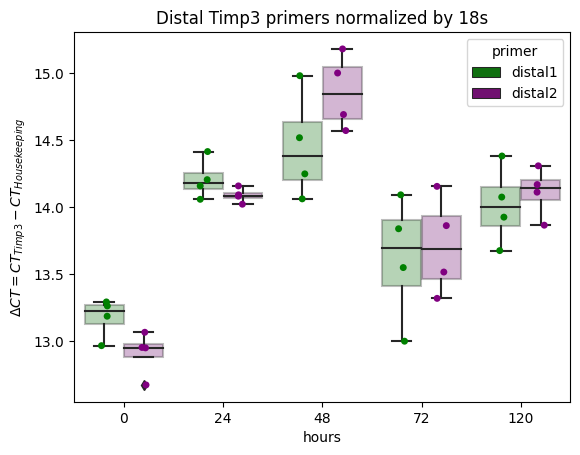

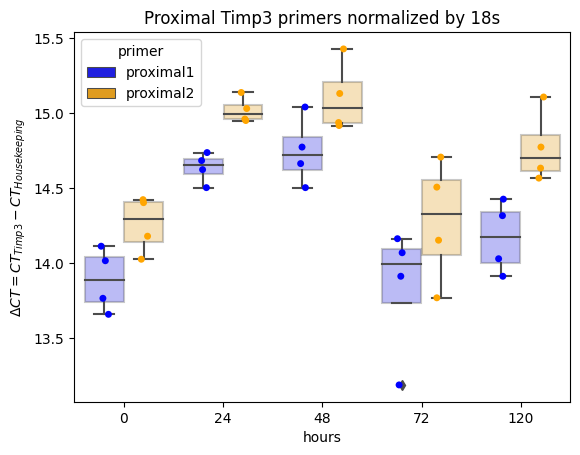

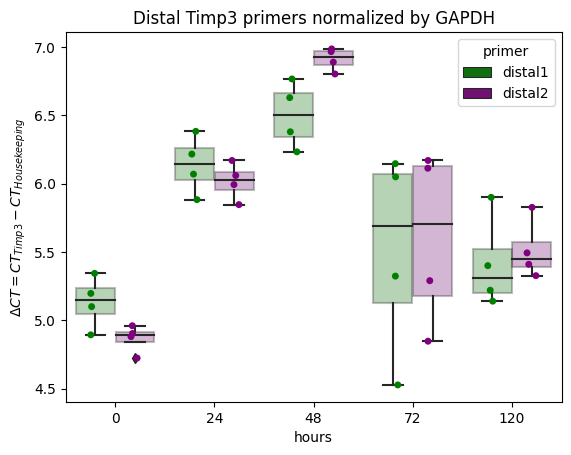

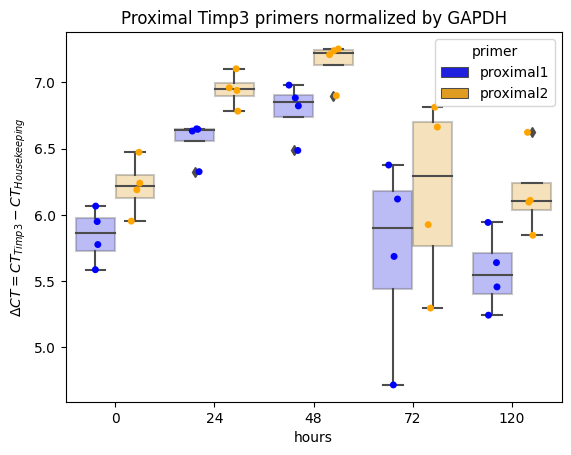

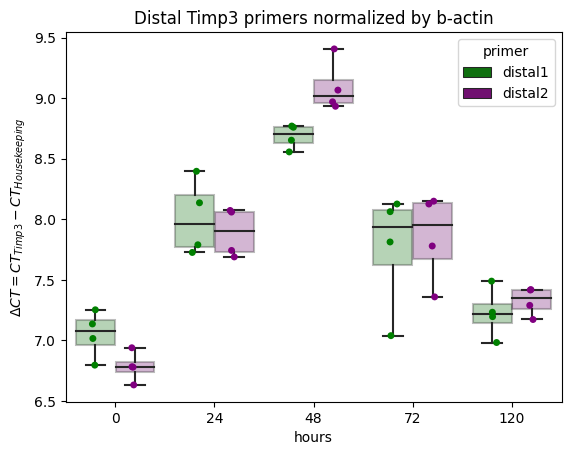

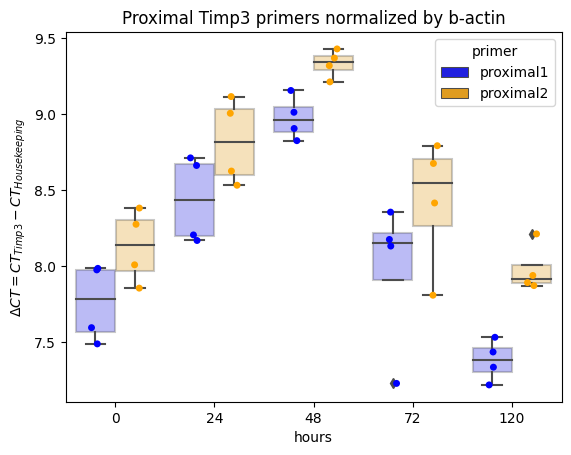

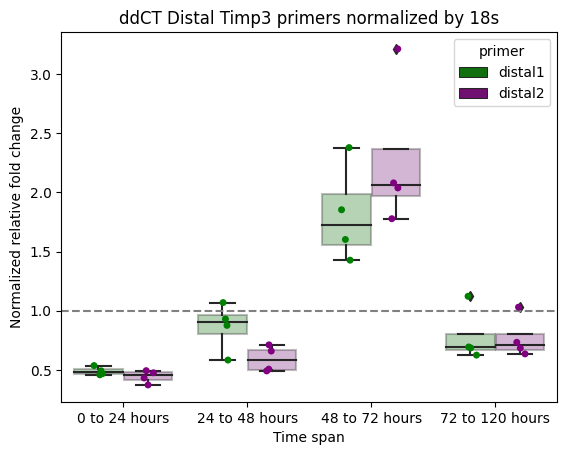

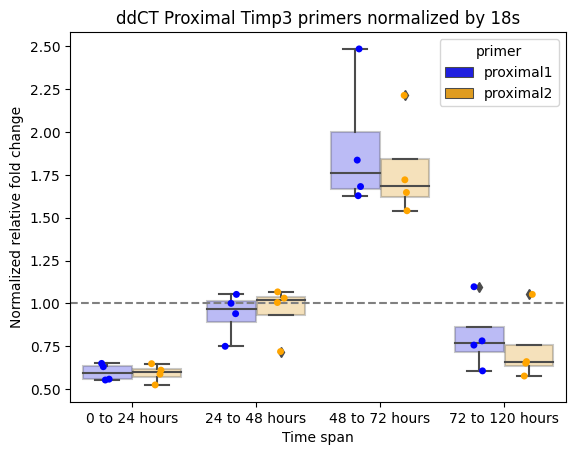

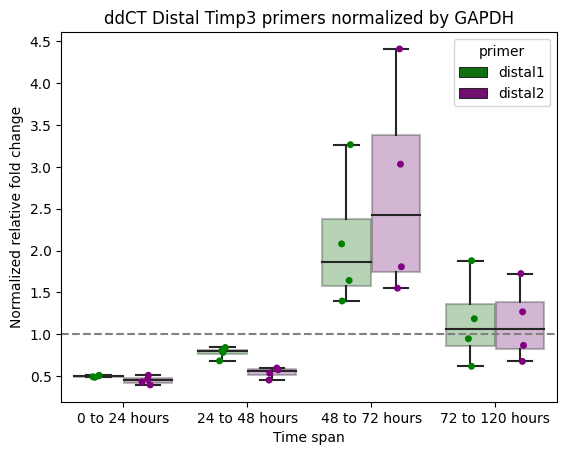

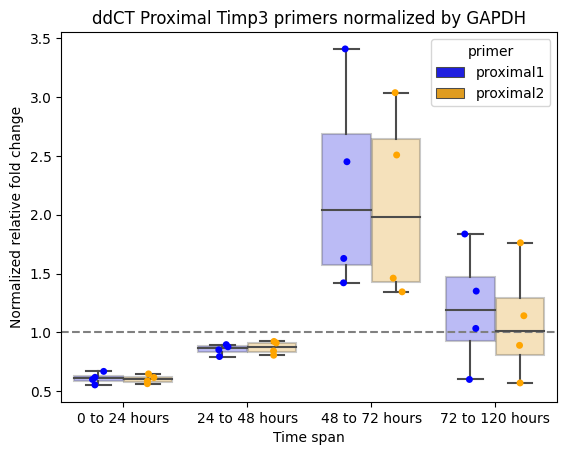

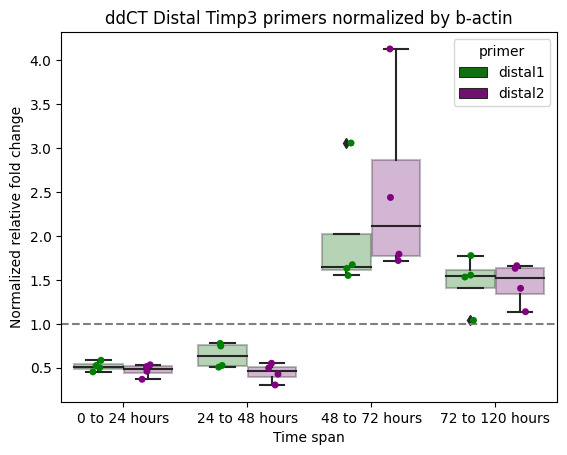

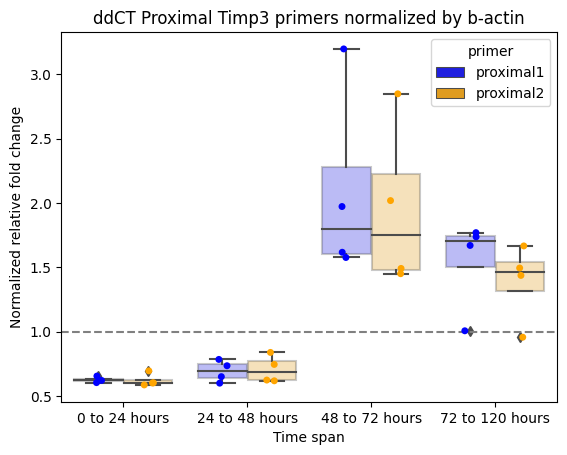

hours,primer,bio_replicate,housekeeping_primer,$\Delta CT_{t1}$,$\Delta CT_{t2}$,t1,t2,$\Delta \Delta CT_{t1-t2}$,fold_change,Time span,Timp3 Primer Location
0,distal1,1,18s,12.966667,14.060000,0,24,-1.093333,0.468677,0 to 24 hours,Distal
1,distal1,1,GAPDH,4.893333,5.883333,0,24,-0.990000,0.503478,0 to 24 hours,Distal
2,distal1,1,b-actin,6.796667,7.726667,0,24,-0.930000,0.524858,0 to 24 hours,Distal
3,distal1,2,18s,13.186667,14.206667,0,24,-1.020000,0.493116,0 to 24 hours,Distal
4,distal1,2,GAPDH,5.196667,6.216667,0,24,-1.020000,0.493116,0 to 24 hours,Distal
...,...,...,...,...,...,...,...,...,...,...,...
43,proximal2,3,GAPDH,5.926667,6.096667,72,120,-0.170000,0.888843,72 to 120 hours,Proximal
44,proximal2,3,b-actin,8.416667,7.893333,72,120,0.523333,1.437272,72 to 120 hours,Proximal
45,proximal2,4,18s,14.506667,15.106667,72,120,-0.600000,0.659754,72 to 120 hours,Proximal
46,proximal2,4,GAPDH,6.813333,6.623333,72,120,0.190000,1.140764,72 to 120 hours,Proximal


In [16]:
#CT trends of proximal and distal primers normalized by housekeeping genes
housekeeping_primers = ['18s','GAPDH','b-actin']
timp3_primers = ['proximal1','proximal2','distal1','distal2']
dCT_df = pd.DataFrame()

for housekeeping_primer in housekeeping_primers:
    #average housekeeping CTs over technical replicates
    housekeeping_CTs = (
        qpcr_df[qpcr_df['primer'].eq(housekeeping_primer)]
        .groupby(['bio_replicate','hours']).agg(
            housekeeping_mean_CT = ('CT','mean'),
            housekeeping_std_CT = ('CT','std'),
        )
        .reset_index()
        .assign(housekeeping_primer=housekeeping_primer)
    )

    #average Timp3 CTs over technical replicates
    timp3_CTs = (
        qpcr_df[qpcr_df['primer'].isin(timp3_primers)]
        .groupby(['primer','bio_replicate','hours']).agg(
            mean_CT = ('CT','mean'),
            std_CT = ('CT','std'),
        )
        .reset_index()
    )

    timp3_hk_cts = timp3_CTs.merge(housekeeping_CTs)
    timp3_hk_cts['dCT'] = timp3_hk_cts['mean_CT']-timp3_hk_cts['housekeeping_mean_CT']
    dCT_df = pd.concat((dCT_df,timp3_hk_cts))

#Plotting dCT values over time, not a publication-ready figure
dCT_df['Timp3 Primer Location'] = np.where(dCT_df['primer'].str.startswith('proximal'),'Proximal','Distal')

dCT_df['${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$'] = dCT_df['dCT']
dCT_df['$2^{-\Delta CT}$'] = 2**(-dCT_df['dCT'])

palette_by_kind = {
    'Proximal':['blue','orange'],
    'Distal':['green','purple'],
}

for (hk_primer,kind),plot_df in dCT_df.groupby(['housekeeping_primer','Timp3 Primer Location']):

    sns.boxplot(
        x = 'hours',
        y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
        hue = 'primer',
        palette = palette_by_kind[kind],
        boxprops=dict(alpha=.3),
        data = plot_df,
    )
    sns.stripplot(
        x = 'hours',
        y = '${\Delta CT = CT_{Timp3}-CT_{Housekeeping}}$',
        hue = 'primer',
        palette = palette_by_kind[kind],
        dodge = True,
        legend = False,
        data = plot_df,
    )
    plt.title(f'{kind} Timp3 primers normalized by {hk_primer}')
    plt.savefig(f'svgs/dCT_{kind}_Timp3_primers_normalized_by_{hk_primer}_boxplot.svg')
    plt.show()
    plt.close()

    
#Calculating delta-delta CT values between sequential timepoints
timepoint_pairs = [
    (0,24),
    (24,48),
    (48,72),
    (72,120),
]

ddCT_df = pd.DataFrame()
for t1,t2 in timepoint_pairs:
    ddCT_t1t2_df = (
        dCT_df[dCT_df['hours'].isin({t1,t2})].pivot(
            index = ['primer','bio_replicate','housekeeping_primer'],
            columns = 'hours',
            values = 'dCT',
        )
        .rename(columns={t1:'$\Delta CT_{t1}$',t2:'$\Delta CT_{t2}$'})
        .assign(t1=t1, t2=t2)
        .reset_index()
    )

    #note this is t1-t2 because larger ct values mean smaller amounts of Timp3
    #when t1 > t2, the ddCT > 0 which will be a positive fold increase
    ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$'] = ddCT_t1t2_df['$\Delta CT_{t1}$']-ddCT_t1t2_df['$\Delta CT_{t2}$']
    ddCT_t1t2_df['fold_change'] = 2**ddCT_t1t2_df['$\Delta \Delta CT_{t1-t2}$']


    ddCT_df = pd.concat((ddCT_df,ddCT_t1t2_df))

ddCT_df['Time span'] = ddCT_df['t1'].astype(str)+' to '+ddCT_df['t2'].astype(str)+' hours'
ddCT_df['Timp3 Primer Location'] = np.where(ddCT_df['primer'].str.startswith('proximal'),'Proximal','Distal')
    
#Plotting ddCT values
for (hk_primer,kind),plot_df in ddCT_df.groupby(['housekeeping_primer','Timp3 Primer Location']):

    sns.boxplot(
        x = 'Time span',
        y = 'fold_change',
        hue = 'primer',
        palette = palette_by_kind[kind],
        boxprops=dict(alpha=.3),
        data = plot_df,
    )
    sns.stripplot(
        x = 'Time span',
        y = 'fold_change',
        hue = 'primer',
        palette = palette_by_kind[kind],
        dodge = True,
        legend = False,
        data = plot_df,
    )
    
    plt.axhline(1, linestyle='dashed', color='grey')
    plt.title(f'ddCT {kind} Timp3 primers normalized by {hk_primer}')
    plt.ylabel('Normalized relative fold change')
    plt.savefig(f'svgs/ddCT_timepoint_{kind}_Timp3_primers_normalized_by_{hk_primer}_boxplot.svg')
    plt.show()
    plt.close()

ddCT_df

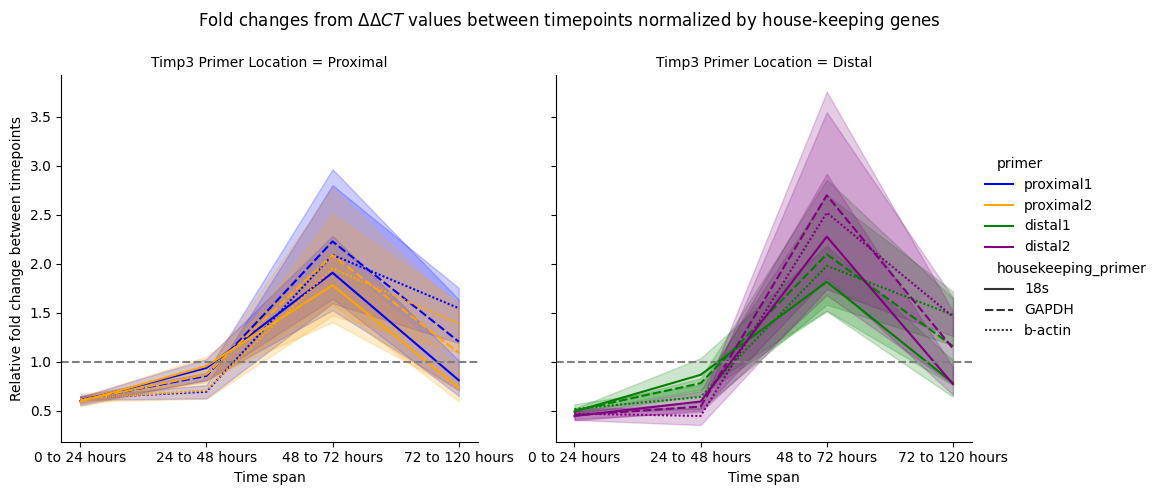

In [17]:
#Aggregate figure to show that the house-keeping gene doesn't matter much
#and that the trends of both proximal and distal primers are the same
g = sns.relplot(
    x = 'Time span',
    y = 'fold_change',
    hue = 'primer',
    hue_order = ['proximal1','proximal2','distal1','distal2'],
    palette = ['blue','orange','green','purple'],
    col = 'Timp3 Primer Location',
    col_order = ['Proximal','Distal'],
    style = 'housekeeping_primer',
    kind = 'line',
    data = ddCT_df,
)
plt.suptitle('Fold changes from $\Delta \Delta CT$ values between timepoints normalized by house-keeping genes')
plt.subplots_adjust(top=0.85)

for ax in g.axes.flatten():
    ax.set_ylabel('Relative fold change between timepoints')
    ax.axhline(1, linestyle='dashed', color='grey')

plt.savefig('svgs/ddCT_aggregate_lineplot.svg')
plt.show()
plt.close()

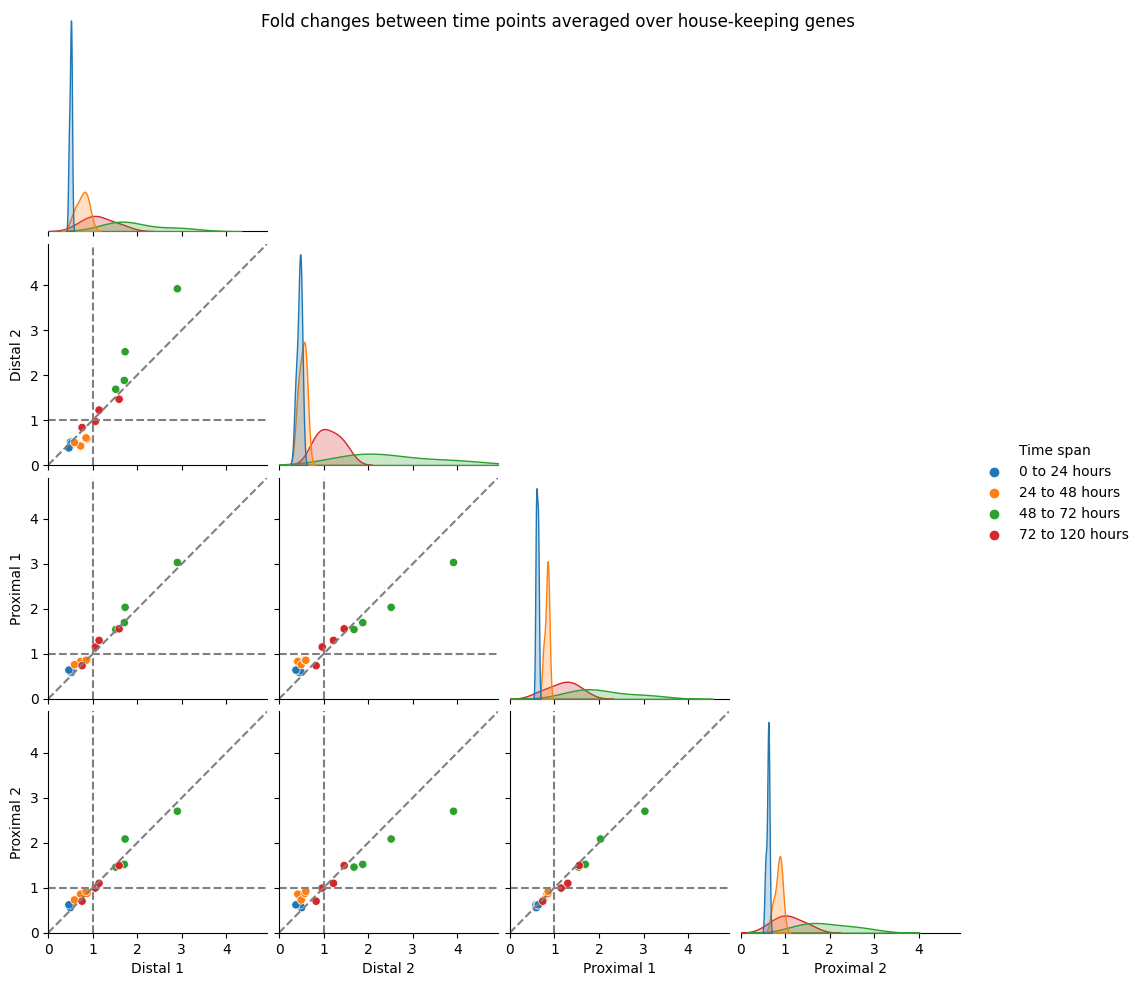

In [18]:
primer_pairs = [
    ('distal1','proximal1'),
    ('distal1','proximal2'),
    ('distal2','proximal1'),
    ('distal2','proximal2'),
]

#averaging ddCT over house-keeping primer
fold_change_piv_df = ddCT_df.pivot_table(
    index = ['Time span','bio_replicate'],
    columns = 'primer',
    values = 'fold_change',
    aggfunc = 'mean',
)

min_fold_change = 0
max_fold_change = fold_change_piv_df.max().max()+1

fold_change_piv_df = fold_change_piv_df.reset_index()

#plotting
g = sns.pairplot(
    fold_change_piv_df.set_index('bio_replicate'),
    corner = True,
    hue = 'Time span',
)

pretty_xy_names = {
    'distal1':'Distal 1',
    'distal2':'Distal 2',
    'proximal1':'Proximal 1',
    'proximal2':'Proximal 2',
}

for i,row_axs in enumerate(g.axes):
    for j,ax in enumerate(row_axs):
        #plotting 'corner=True' results in null axes
        if not ax:
            continue
        
        #make the x and y labels nicer looking
        ax.set_xlabel(pretty_xy_names.get(ax.get_xlabel()))
        ax.set_ylabel(pretty_xy_names.get(ax.get_ylabel()))
        
        #adjust xlim for all subplots, even diagonal
        ax.set_xlim(min_fold_change, max_fold_change)
        
        #don't add y=x line for the diagonal entries
        if i == j:
            continue
            
        ax.axline((0, 0), slope=1, linestyle='dashed', color='grey')
        ax.axhline(1, linestyle='dashed', color='grey')
        ax.axvline(1, linestyle='dashed', color='grey')
        
        #only adjust ylim for off-diagonals
        ax.set_ylim(min_fold_change, max_fold_change)
        
plt.suptitle('Fold changes between time points averaged over house-keeping genes')
plt.savefig('svgs/pairplot_foldchange_qPCR.svg')
plt.show()
plt.close()

In [6]:
#Calculating 2^-(CT_total-CT_long) per technical replicate
#to check if the value is ever less than 1 which is unexpected

pd_pairs = itertools.product(['proximal1', 'proximal2'],['distal1', 'distal2'])
piv_dfs = []
for p,d in pd_pairs:
    pd_df = qpcr_df[qpcr_df['primer'].isin({p,d})]
    
    #create a pivoted df w/ the following columns:
    #  bio_replicate  tech_replicate  hours  dist_CT   prox_CT  prox_primer   dist_primer 
    #              1               1      0    22.84     23.69    proximal1        distal1
    #              1               1     24    23.42     24.29    proximal1        distal1
    #              1               1     48    23.71     24.02    proximal1        distal1
    #              1               1     72    22.23     22.46    proximal1        distal1
    #              1               1    120    22.85     23.23    proximal1        distal1
    piv_df = (
        pd_df.pivot(
            index=['bio_replicate','tech_replicate','hours'],
            columns='primer',
            values='CT',
        )
        .reset_index()
        .rename(columns={p:'prox_CT',d:'dist_CT'})
        .assign(prox_primer=p, dist_primer=d)
    )
    
    piv_dfs.append(piv_df)
    

bio_tech_rep_cts = pd.concat(piv_dfs)
bio_tech_rep_cts['P/D'] = 2**(bio_tech_rep_cts.dist_CT-bio_tech_rep_cts.prox_CT)
bio_tech_rep_cts

primer,bio_replicate,tech_replicate,hours,dist_CT,prox_CT,prox_primer,dist_primer,P/D
0,1,1,0,22.84,23.69,proximal1,distal1,0.554785
1,1,1,24,23.42,24.29,proximal1,distal1,0.547147
2,1,1,48,23.71,24.02,proximal1,distal1,0.806642
3,1,1,72,22.23,22.46,proximal1,distal1,0.852635
4,1,1,120,22.85,23.23,proximal1,distal1,0.768438
...,...,...,...,...,...,...,...,...
55,4,3,0,22.43,24.34,proximal2,distal2,0.266093
56,4,3,24,23.69,24.91,proximal2,distal2,0.429283
57,4,3,48,24.24,24.67,proximal2,distal2,0.742262
58,4,3,72,23.45,23.87,proximal2,distal2,0.747425


In [7]:
bio_tech_rep_cts['P/D'].ge(1).value_counts()

False    219
True      21
Name: P/D, dtype: int64

In [8]:
bio_tech_rep_cts.groupby(['prox_primer','dist_primer'])['P/D'].apply(lambda v: v.ge(1).value_counts())

prox_primer  dist_primer       
proximal1    distal1      False    56
                          True      4
             distal2      False    46
                          True     14
proximal2    distal1      False    60
             distal2      False    57
                          True      3
Name: P/D, dtype: int64

In [9]:
#Average the qPCR technical replicates to get mean and std CT per primer, replicate, hour
agg_cts = qpcr_df.groupby(['bio_replicate','hours','primer']).agg(
    mean_CT = ('CT','mean'),
    std_CT = ('CT','std'),
).reset_index()

agg_cts

,bio_replicate,hours,primer,mean_CT,std_CT
0,1,0,18s,9.960000,0.125300
1,1,0,GAPDH,18.033333,0.115902
2,1,0,b-actin,16.130000,0.050000
3,1,0,distal1,22.926667,0.096090
4,1,0,distal2,22.913333,0.207926
...,...,...,...,...,...
135,4,120,b-actin,15.973333,0.168028
136,4,120,distal1,23.463333,0.150444
137,4,120,distal2,23.390000,0.149332
138,4,120,proximal1,23.506667,0.015275


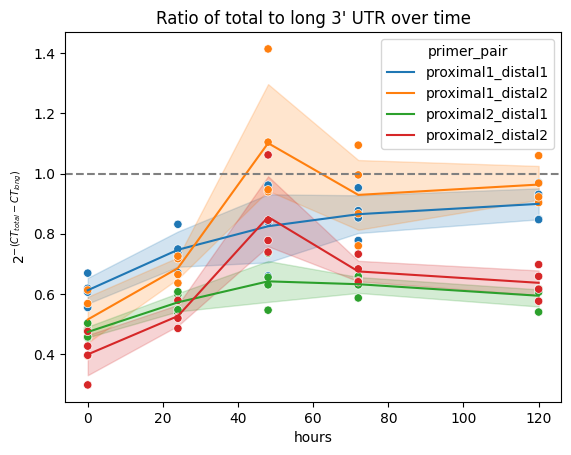

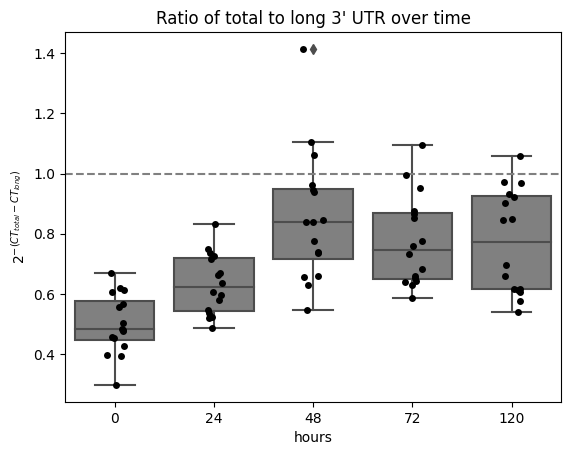

In [10]:
#calculate 2^-(CT_total-CT_long) for all 4 pairs of TOTAL/LONG primers at each time
pairwise_CT = pd.DataFrame()

for s,l in itertools.product(['proximal1', 'proximal2'],['distal1', 'distal2']):
    sl_df = agg_cts[agg_cts['primer'].isin({s,l})]
    sl_df = sl_df.pivot(
        index=['bio_replicate','hours'],
        columns='primer',
        values='mean_CT',
    ).reset_index()
    
    sl_df['dCT'] = 2**-(sl_df[s]-sl_df[l])
    sl_df['primer_pair'] = s+'_'+l
    sl_df = sl_df.rename(columns={s:'short_primer',l:'long_primer'})

    pairwise_CT = pd.concat((pairwise_CT,sl_df))
    
    
#Plot the dCT for each pair of primers
sns.lineplot(
    x = 'hours',
    y = 'dCT',
    hue = 'primer_pair',
    data = pairwise_CT,
)
sns.scatterplot(
    x = 'hours',
    y = 'dCT',
    hue = 'primer_pair',
    legend = False,
    data = pairwise_CT,
)
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.title("Ratio of total to long 3' UTR over time")
plt.ylabel('$2^{-(CT_{total}-CT_{long})}$')
plt.savefig('svgs/dCT_total_vs_long_per_primer_pair.svg')
plt.show()
plt.close()


#Plot the dCT averaged over all primer pairs
sns.boxplot(
    x = 'hours',
    y = 'dCT',
    color = 'grey',
    data = pairwise_CT,
)
sns.stripplot(
    x = 'hours',
    y = 'dCT',
    color = 'black',
    data = pairwise_CT,
)
plt.axhline(y=1, linestyle='dashed', color='grey')
plt.ylabel('$2^{-(CT_{total}-CT_{long})}$')
plt.title("Ratio of total to long 3' UTR over time")
plt.savefig('svgs/dCT_total_vs_long.svg')
plt.show()
plt.close()

In [11]:
#Finding which shifts in time are significantly different by ttest
#(0 --> 24) and (24 --> 48) are statistically significant
data = {
    'time1':[],
    'time2':[],
    't':[],
    'p':[],   
}
time_pairs = [
    (0,24),
    (24,48),
    (48,72),
    (72,120),
]

for t1,t2 in time_pairs:
    x1 = pairwise_CT[pairwise_CT['hours'].eq(t1)]['dCT']
    x2 = pairwise_CT[pairwise_CT['hours'].eq(t2)]['dCT']
    t,p = scp.stats.ttest_ind(x1,x2)
    data['time1'].append(t1)
    data['time2'].append(t2)
    data['t'].append(t)
    data['p'].append(p)

ttest_df = pd.DataFrame(data)
ttest_df['significant'] = ttest_df['p'].le(0.05/len(time_pairs)) #Bonferroni correction
ttest_df

,time1,time2,t,p,significant
0,0,24,-3.773095,0.000710,True
1,24,48,-3.743821,0.000768,True
2,48,72,1.225044,0.230091,False
3,72,120,0.032674,0.974151,False


# Protein concentration analysis

??? Wetlab methods description ??? 

??? Analysis methods description ???


In [12]:
conc_df = pd.read_csv('input_csvs/timp3_protein_concentrations.csv')

#constants used in analysis
culture_volume = 2 #2 mLs
timp3_halflife = 15 #~15 hours: https://www.nature.com/articles/s41419-021-04192-8
frac_timp3_24_hours = 0.5**(24/15) #fraction of original Timp3 left after 24 hours

conc_df

,hours,replicate,BCA (ng/mL),cells,timp3 (ng/mL)
0,0,1,5497.8,120000.0,0.0139
1,0,2,4919.9,120000.0,0.0269
2,0,3,5151.1,120000.0,0.0659
3,0,4,4919.9,120000.0,0.0225
4,24,1,5547.3,159000.0,0.5555
5,24,2,5365.7,152000.0,0.6464
6,24,3,5695.9,149000.0,0.7244
7,24,4,5745.4,176000.0,0.6118
8,48,1,5728.9,249000.0,1.7080
9,48,2,5464.8,209000.0,1.7166


In [13]:
#remove the 120 hour timepoint, Jui said the cells were dying and this is her recommendation
conc_df = conc_df[conc_df['hours'].lt(120)].copy()

#substract t=0 timp3 concentration from each replicate
conc_df['timp3 (ng/mL)'] = conc_df.groupby('replicate')['timp3 (ng/mL)'].transform(
    lambda timp3s: timp3s-min(timp3s)
)

#Convert the concentrations into ng's using the culture volume
conc_df['BCA (ng/mL)'] *= culture_volume
conc_df['timp3 (ng/mL)'] *= culture_volume

conc_df = conc_df.rename(columns={'BCA (ng/mL)':'BCA (ng)','timp3 (ng/mL)':'Timp3 (ng)'})
conc_df

,hours,replicate,BCA (ng),cells,Timp3 (ng)
0,0,1,10995.6,120000.0,0.0000
1,0,2,9839.8,120000.0,0.0000
2,0,3,10302.2,120000.0,0.0000
3,0,4,9839.8,120000.0,0.0000
4,24,1,11094.6,159000.0,1.0832
5,24,2,10731.4,152000.0,1.2390
6,24,3,11391.8,149000.0,1.3170
7,24,4,11490.8,176000.0,1.1786
8,48,1,11457.8,249000.0,3.3882
9,48,2,10929.6,209000.0,3.3794


,replicate,t1,t2,starting Timp3 (ng),ending Timp3 (ng),degraded Timp3 (ng),created Timp3 (ng),starting cells,ending cells,Time span,Secreted Timp3 ng per cell per hour
0,1,0,24,0.0000,1.0832,0.000000,1.083200,120000.0,159000.0,0-hrs to 24-hrs,3.761111e-07
1,1,24,48,1.0832,3.3882,0.357323,2.662323,159000.0,249000.0,24-hrs to 48-hrs,6.976737e-07
2,1,48,72,3.3882,7.4436,1.117689,5.173089,249000.0,201000.0,48-hrs to 72-hrs,8.656441e-07
3,2,0,24,0.0000,1.2390,0.000000,1.239000,120000.0,152000.0,0-hrs to 24-hrs,4.302083e-07
4,2,24,48,1.2390,3.3794,0.408718,2.549118,152000.0,209000.0,24-hrs to 48-hrs,6.987713e-07
5,2,48,72,3.3794,5.4072,1.114786,3.142586,209000.0,230000.0,48-hrs to 72-hrs,6.265124e-07
6,3,0,24,0.0000,1.3170,0.000000,1.317000,120000.0,149000.0,0-hrs to 24-hrs,4.572917e-07
7,3,24,48,1.3170,4.2286,0.434448,3.346048,149000.0,151000.0,24-hrs to 48-hrs,9.356957e-07
8,3,48,72,4.2286,8.6134,1.394918,5.779718,151000.0,182000.0,48-hrs to 72-hrs,1.594845e-06
9,4,0,24,0.0000,1.1786,0.000000,1.178600,120000.0,176000.0,0-hrs to 24-hrs,4.092361e-07


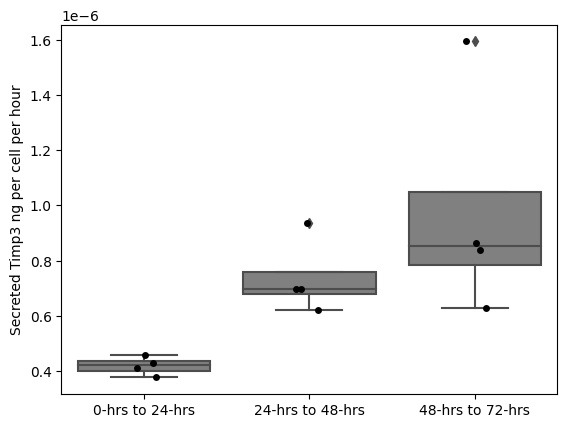

In [14]:
#Group by replicate and convert Timp3 protein values to time-spans
time_spans = [(0,24),(24,48),(48,72)]
data = collections.defaultdict(list)

for r,g in conc_df.groupby('replicate'):
    g = g.set_index('hours')
    for t1,t2 in time_spans:
        starting_timp3 = g.loc[t1]['Timp3 (ng)']
        ending_timp3 = g.loc[t2]['Timp3 (ng)']
        degraded_timp3 = g.loc[t1]['Timp3 (ng)']*frac_timp3_24_hours
        
        data['replicate'].append(r)
        data['t1'].append(t1)
        data['t2'].append(t2)
        data['starting Timp3 (ng)'].append(starting_timp3)
        data['ending Timp3 (ng)'].append(ending_timp3)
        data['degraded Timp3 (ng)'].append(degraded_timp3)
        data['created Timp3 (ng)'].append(ending_timp3-(starting_timp3-degraded_timp3))
        data['starting cells'].append(g.loc[t1]['cells'])
        data['ending cells'].append(g.loc[t2]['cells'])


time_span_conc_df = pd.DataFrame(data)
time_span_conc_df['Time span'] = (
    time_span_conc_df['t1'].astype(str)+'-hrs to '
    +time_span_conc_df['t2'].astype(str)+'-hrs'
)

time_span_conc_df['Secreted Timp3 ng per cell per hour'] = (
    time_span_conc_df['created Timp3 (ng)'].divide(
        time_span_conc_df['starting cells']
    ).divide(
        time_span_conc_df['t2']-time_span_conc_df['t1']
    )
)

display(time_span_conc_df)

#Make a simple boxplot
sns.boxplot(
    x = 'Time span',
    y = 'Secreted Timp3 ng per cell per hour',
    color = 'grey',
    data = time_span_conc_df,
)

sns.stripplot(
    x = 'Time span',
    y = 'Secreted Timp3 ng per cell per hour',
    color = 'black',
    data = time_span_conc_df,
)
plt.xlabel('')
plt.savefig('svgs/secreted_timp3_protein_per_cell_per_hour.svg')
plt.show()
plt.close()

# Combining qPCR and ELISA data

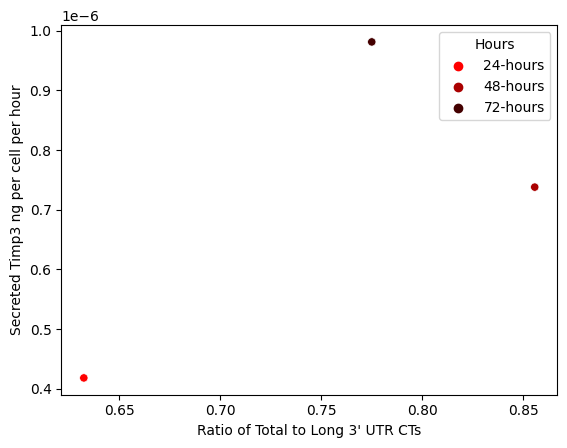

In [15]:
qpcr_series = pairwise_CT.groupby('hours')['dCT'].mean()
conc_series = time_span_conc_df.groupby('t2')['Secreted Timp3 ng per cell per hour'].mean()

joint_df = pd.concat((qpcr_series,conc_series),axis=1).reset_index()
joint_df['Hours'] = joint_df['index'].astype(str)+'-hours'

sns.scatterplot(
    x = "dCT",
    y = 'Secreted Timp3 ng per cell per hour',
    hue = 'Hours',
    palette = ['#ff0000','#aa0000','#440000'],
    data = joint_df.dropna(),
)
plt.xlabel("Ratio of Total to Long 3' UTR CTs")
plt.savefig('svgs/secretion_vs_CT.svg')
plt.show()
plt.close()

In [38]:
len(dfs)

1

In [101]:
del df

In [136]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

url = 'https://www.basketball-reference.com/boxscores/pbp/200911060GSW.html'
dfs = pd.read_html(url)

df = dfs[0] 
df.rename(columns={'Unnamed: 2_level_1': 'PM1', 'Unnamed: 4_level_1': 'PM2'}, inplace=True)

df.columns = df.columns.droplevel() #columns currently multiindex, you don't need 1st Q, drop it
df = df[df['Time'].str.contains(':')] #only include rows with a real 'Time' that contains a colon, excludes headers

#Identify which rows signify the start of a new quarter
#has to have 12 minutes of time and text of 'Start of...' in the 'Score' column
quarter_start_rows = df['Time'].eq('12:00.0') & df['Score'].str.startswith('Start of')

#create a new column called quarter w/ 1 at new quarter, 0 otherwise then cumsum
df['Quarter'] = np.where(quarter_start_rows,1,0).cumsum()

#separate the minutes and seconds and make them int and float respectively
df[['Minutes','Seconds']] = df['Time'].str.split(':',expand=True).astype({0:'int',1:'float'})

#represent Q2 11:30 as 11.5 etc so it is easy to add/subtract times
fractional_time = df['Minutes'].add(df['Seconds'].div(60))

#convert from Q2 11:30 (11.5) to 'global time' which would be 35.5
global_fractional_time = fractional_time.add((4-df['Quarter'])*12)

#convert from fractional time back to Minutes and Seconds
minutes = global_fractional_time.astype(int)
seconds = global_fractional_time.sub(minutes).multiply(60).round(1)

#Make a new string column to show the global minutes and seconds more nicely
df['Overall Time'] = minutes.astype(str).str.zfill(2)+':'+seconds.astype(str).str.zfill(4)

df

,Time,LA Clippers,PM1,Score,PM2,Golden State,Quarter,Minutes,Seconds,Overall Time
0,12:00.0,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,1,12,0.0,48:00.0
1,12:00.0,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,1,12,0.0,48:00.0
2,11:46.0,C. Kaman makes 2-pt jump shot from 19 ft (assi...,+2,2-0,NaN,NaN,1,11,46.0,47:46.0
3,11:31.0,NaN,NaN,2-0,NaN,Shooting foul by R. Butler (drawn by M. Ellis),1,11,31.0,47:31.0
4,11:31.0,NaN,NaN,2-0,NaN,M. Ellis misses free throw 1 of 2,1,11,31.0,47:31.0
...,...,...,...,...,...,...,...,...,...,...
477,0:32.0,NaN,NaN,118-87,NaN,Offensive rebound by K. Azubuike,4,0,32.0,00:32.0
478,0:27.7,NaN,NaN,118-90,+3,A. Morrow makes 3-pt jump shot from 25 ft (ass...,4,0,27.7,00:27.7
479,0:04.9,S. Telfair misses 2-pt jump shot from 19 ft,NaN,118-90,NaN,NaN,4,0,4.9,00:04.9
480,0:03.8,NaN,NaN,118-90,NaN,Defensive rebound by A. Morrow,4,0,3.8,00:03.8


In [134]:
seconds

0       0.0
1       0.0
2      46.0
3      31.0
4      31.0
       ... 
477    32.0
478    27.7
479     4.9
480     3.8
481     0.0
Length: 476, dtype: float64

In [131]:
df['time']

KeyError: 'time'

In [113]:
df['Time'].str.split(':',expand=True).astype(float)

,0,1
0,12.0,0.0
1,12.0,0.0
2,11.0,46.0
3,11.0,31.0
4,11.0,31.0
...,...,...
477,0.0,32.0
478,0.0,27.7
479,0.0,4.9
480,0.0,3.8


In [89]:
df[['Minutes','Seconds']] = df['Time'].str.split(':',expand=True).astype({0:'int',1:'float'})
df
df.dtypes

/tmp/ipykernel_12443/23676539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Minutes','Seconds']] = df['Time'].str.split(':',expand=True).astype({0:'int',1:'float'})
/tmp/ipykernel_12443/23676539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Minutes','Seconds']] = df['Time'].str.split(':',expand=True).astype({0:'int',1:'float'})


Time             object
LA Clippers      object
PM1              object
Score            object
PM2              object
Golden State     object
quarter           int64
Minutes           int64
Seconds         float64
dtype: object

In [90]:
df

,Time,LA Clippers,PM1,Score,PM2,Golden State,quarter,Minutes,Seconds
0,12:00.0,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,Start of 1st quarter,1,12,0.0
1,12:00.0,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,Jump ball: M. Moore vs. M. Camby (R. Butler ga...,1,12,0.0
2,11:46.0,C. Kaman makes 2-pt jump shot from 19 ft (assi...,+2,2-0,NaN,NaN,1,11,46.0
3,11:31.0,NaN,NaN,2-0,NaN,Shooting foul by R. Butler (drawn by M. Ellis),1,11,31.0
4,11:31.0,NaN,NaN,2-0,NaN,M. Ellis misses free throw 1 of 2,1,11,31.0
...,...,...,...,...,...,...,...,...,...
477,0:32.0,NaN,NaN,118-87,NaN,Offensive rebound by K. Azubuike,4,0,32.0
478,0:27.7,NaN,NaN,118-90,+3,A. Morrow makes 3-pt jump shot from 25 ft (ass...,4,0,27.7
479,0:04.9,S. Telfair misses 2-pt jump shot from 19 ft,NaN,118-90,NaN,NaN,4,0,4.9
480,0:03.8,NaN,NaN,118-90,NaN,Defensive rebound by A. Morrow,4,0,3.8


In [62]:
df['quarter'].cumsum(skipna=False)

0      1.0
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
477    NaN
478    NaN
479    NaN
480    NaN
481    NaN
Name: quarter, Length: 482, dtype: float64